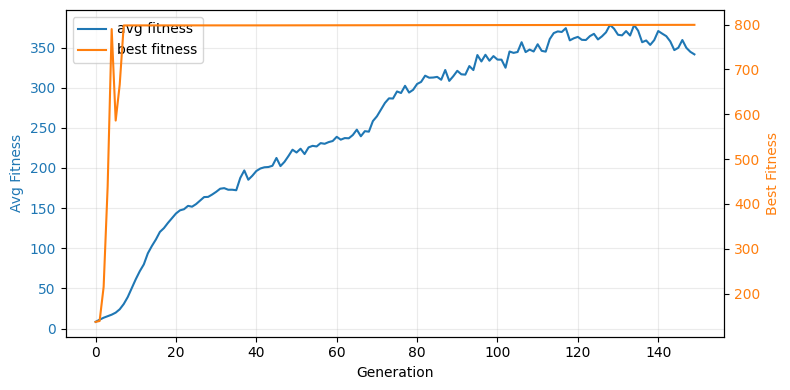

[GEN 0150] avg_fit=341.507  best_fit=799.304  avg_density=0.2707  (pen=3.000, N=224)


In [1]:
# ============================================================
# EM33 CartPole (episodic) — Taichi-only env+model, GA-compatible
#  - Population axis is A everywhere
#  - Genome: R (A,27) int8 values in {0,1,2}, and S_init (A,N) int8 in {0,1,2}
#  - Episode fitness: number of control steps survived (dead => never revives; +0 forever)
#  - Inputs are written into I-cells before microsteps AND re-written after every microstep
#    (so program only effectively acts on non-input zone)
#  - Density penalty: computed on raw genome S_init on CPU
#  - No deterministic seeding anywhere (no np.random.seed, no ti.seed)
# ============================================================

import numpy as np
import taichi as ti
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

from general_ga import GA, GAConfig, VarSpec

# -----------------------------
# Taichi init (LOUD fail if CUDA not available)
# -----------------------------
ti.init(arch=ti.cuda)

# -----------------------------
# Hyperparams (edit here)
# -----------------------------
CFG = dict(
    # Population / EM33 tape layout
    A=4096,       # population size
    K=8,          # bins per variable
    Np=6,         # program cells per bin
    Vars=4,       # cartpole vars (x, xdot, theta, thetadot)

    # EM33 dynamics
    T=32,         # CA microsteps per control step

    # Decode -> force
    force_scale=9.0,
    force_bias_b=3.0,
    force_noise_std=0.15,
    u_max=10.0,

    # CartPole physics
    dt=0.02,
    n_substeps=1,
    gravity=9.8,
    masscart=1.0,
    masspole=0.1,
    length=0.5,  # half-length
    x_threshold=2.4,
    theta_threshold_rad=12 * np.pi / 180.0,

    # Observation discretization
    obs_min=np.array([-2.4, -3.0, -0.2095, -3.5], dtype=np.float32),
    obs_max=np.array([ 2.4,  3.0,  0.2095,  3.5], dtype=np.float32),

    # Episode
    steps_per_episode=800,

    # Env init noise (per component std)
    init_state_std=np.array([0.5, 0.1, 0.05, 0.1], dtype=np.float32),

    # GA
    generations=150,
    elitism=200,
    tournament_k=6,
    immigrants_per_gen=1,
    bank_max=256,
    bank_add_every=1,

    # Variation (per-element)
    crossover_prob=0.02,
    p_rule_mut=0.02,
    p_state_mut=0.02,

    # Density penalty (tiny): fitness -= density_penalty * (nnz(S_init)/N)
    density_penalty=3,
)

assert CFG["Vars"] == 4, "This code assumes Vars=4 for CartPole."
assert CFG["A"] >= 2 and CFG["K"] >= 2 and CFG["Np"] >= 1
assert CFG["T"] >= 1 and CFG["steps_per_episode"] >= 1
assert CFG["n_substeps"] >= 1

# Derived tape size
stride = 1 + CFG["Np"]
Lvar = CFG["K"] * stride
N = CFG["Vars"] * Lvar

# -----------------------------
# GA builder (uses your general_ga.py semantics)
# Values enforced to be in {0,1,2} via int_uniform with [0,3)
# -----------------------------
def build_ga(cfg: dict) -> GA:
    A = int(cfg["A"])
    var_specs = [
        VarSpec(
            name="R",
            dtype="int8",
            shape=(A, 27),
            trainable=True,
            init_mode="int_uniform",
            min_val=0,          # inclusive
            max_val=3,          # exclusive -> {0,1,2}
            mut_type="resample",
            mut_prob=float(cfg["p_rule_mut"]),
            sigma_base=0.0,
            crossover_prob=float(cfg["crossover_prob"]),
            resample_min=0,
            resample_max=3,
        ),
        VarSpec(
            name="S_init",
            dtype="int8",
            shape=(A, N),
            trainable=True,
            init_mode="int_uniform",
            min_val=0,
            max_val=3,
            mut_type="resample",
            mut_prob=float(cfg["p_state_mut"]),
            sigma_base=0.0,
            crossover_prob=float(cfg["crossover_prob"]),
            resample_min=0,
            resample_max=3,
        ),
    ]

    ga_cfg = GAConfig(
        population_size=A,
        elitism=int(cfg["elitism"]),
        tournament_k=int(cfg["tournament_k"]),
        immigrants_per_gen=int(cfg["immigrants_per_gen"]),
        bank_max=int(cfg["bank_max"]),
        bank_add_every=int(cfg["bank_add_every"]),
        # float-additive knobs (unused here, but still valid)
        eps_adapt=1e-3,
        t_df=2.0,
        noise_dist="student_t",
    )
    return GA(ga_cfg, var_specs)

# -----------------------------
# Taichi system: env + EM33
# -----------------------------
@ti.data_oriented
class EM33CartPoleSystem:
    def __init__(self, cfg: dict):
        self.A = int(cfg["A"])
        self.K = int(cfg["K"])
        self.Np = int(cfg["Np"])
        self.Vars = int(cfg["Vars"])
        self.T = int(cfg["T"])

        self.stride = 1 + self.Np
        self.Lvar = self.K * self.stride
        self.N = self.Vars * self.Lvar

        # ---- model fields ----
        # store as i32 for arithmetic; values remain 0..2
        self.mdl_R = ti.field(dtype=ti.i32, shape=(self.A, 27))
        self.mdl_S_init = ti.field(dtype=ti.i32, shape=(self.A, self.N))

        self.mdl_S = ti.field(dtype=ti.i32, shape=(self.A, self.N))
        self.mdl_S_next = ti.field(dtype=ti.i32, shape=(self.A, self.N))

        # bins per agent per var
        self.mdl_bins = ti.field(dtype=ti.i32, shape=(self.A, self.Vars))

        # ---- env fields ----
        self.env_E = ti.field(dtype=ti.f32, shape=(self.A, 4))  # x, xdot, th, thdot
        self.env_alive = ti.field(dtype=ti.i32, shape=(self.A,))

        # ---- episode accumulator ----
        self.epi_fit = ti.field(dtype=ti.i32, shape=(self.A,))

        # ---- config arrays ----
        self.obs_min = ti.field(dtype=ti.f32, shape=(self.Vars,))
        self.obs_max = ti.field(dtype=ti.f32, shape=(self.Vars,))
        self.init_std = ti.field(dtype=ti.f32, shape=(self.Vars,))

        self.obs_min.from_numpy(np.asarray(cfg["obs_min"], dtype=np.float32))
        self.obs_max.from_numpy(np.asarray(cfg["obs_max"], dtype=np.float32))
        self.init_std.from_numpy(np.asarray(cfg["init_state_std"], dtype=np.float32))

        # scalars
        self.dt = float(cfg["dt"])
        self.g = float(cfg["gravity"])
        self.mc = float(cfg["masscart"])
        self.mp = float(cfg["masspole"])
        self.l = float(cfg["length"])
        self.x_th = float(cfg["x_threshold"])
        self.th_th = float(cfg["theta_threshold_rad"])

        self.force_scale = float(cfg["force_scale"])
        self.force_bias_b = float(cfg["force_bias_b"])
        self.force_noise_std = float(cfg["force_noise_std"])
        self.u_max = float(cfg["u_max"])

        # compile-time ints (use self.* in ti.static loops)
        self._K_static = self.K
        self._T_static = self.T
        self._nsub_static = int(cfg["n_substeps"])

    def load_genome(self, pop: dict):
        R = pop["R"]
        S0 = pop["S_init"]
        assert isinstance(R, np.ndarray) and isinstance(S0, np.ndarray)
        assert R.shape == (self.A, 27)
        assert S0.shape == (self.A, self.N)
        assert R.dtype == np.int8, f"Expected R int8 from GA, got {R.dtype}"
        assert S0.dtype == np.int8, f"Expected S_init int8 from GA, got {S0.dtype}"

        # Immutable: 000 -> 0
        R = R.copy()
        R[:, 0] = 0

        self.mdl_R.from_numpy(R.astype(np.int32, copy=False))
        self.mdl_S_init.from_numpy(S0.astype(np.int32, copy=False))
        self._enforce_rule000()

    @ti.kernel
    def _enforce_rule000(self):
        for a in range(self.A):
            self.mdl_R[a, 0] = 0

    @ti.func
    def _clip01(self, x: ti.f32) -> ti.f32:
        x = ti.max(0.0, x)
        x = ti.min(0.999999, x)
        return x

    @ti.kernel
    def reset_episode(self):
        for a in range(self.A):
            self.env_alive[a] = 1
            self.epi_fit[a] = 0

            # env init noise (no deterministic seed)
            for i in ti.static(range(4)):
                self.env_E[a, i] = ti.randn(ti.f32) * self.init_std[i]

            # tape init
            for j in range(self.N):
                self.mdl_S[a, j] = self.mdl_S_init[a, j]
                self.mdl_S_next[a, j] = 0

    @ti.func
    def _discretize_into_bins(self, a: ti.i32):
        for v in ti.static(range(4)):
            mn = self.obs_min[v]
            mx = self.obs_max[v]
            val = self.env_E[a, v]
            z = (val - mn) / (mx - mn)
            z = self._clip01(z)
            b = ti.cast(z * ti.cast(self.K, ti.f32), ti.i32)
            if b < 0:
                b = 0
            if b > self.K - 1:
                b = self.K - 1
            self.mdl_bins[a, v] = b

    @ti.func
    def _overwrite_inputs(self, a: ti.i32, Sbuf: ti.template()):
        # Set all I-cells to 0, then set selected bin per var to 2.
        for v in ti.static(range(4)):
            base = v * self.Lvar
            for k in ti.static(range(self._K_static)):
                pos = base + k * self.stride
                Sbuf[a, pos] = 0
            kk = self.mdl_bins[a, v]
            Sbuf[a, base + kk * self.stride] = 2

    @ti.func
    def _evolve_microsteps(self, a: ti.i32):
        for _ in ti.static(range(self._T_static)):
            for j in range(self.N):
                left  = self.mdl_S[a, (j - 1 + self.N) % self.N]
                cen   = self.mdl_S[a, j]
                right = self.mdl_S[a, (j + 1) % self.N]
                idx = left * 9 + cen * 3 + right  # 0..26
                self.mdl_S_next[a, j] = self.mdl_R[a, idx]  # 0..2

            # enforce inputs after each microstep
            self._overwrite_inputs(a, self.mdl_S_next)

            # copy back
            for j in range(self.N):
                self.mdl_S[a, j] = self.mdl_S_next[a, j]

    @ti.func
    def _decode_force(self, a: ti.i32) -> ti.f32:
        Lsum = ti.cast(0, ti.i32)
        Rsum = ti.cast(0, ti.i32)

        for v in ti.static(range(4)):
            base = v * self.Lvar
            for k in ti.static(range(self._K_static)):
                i_pos = base + k * self.stride
                if self.mdl_S[a, (i_pos - 1 + self.N) % self.N] == 2:
                    Lsum += 1
                if self.mdl_S[a, (i_pos + 1) % self.N] == 2:
                    Rsum += 1

        Lf = ti.cast(Lsum, ti.f32)
        Rf = ti.cast(Rsum, ti.f32)

        u = self.force_scale * ((Rf - Lf) / (Rf + Lf + self.force_bias_b))

        # (keeping your current bang-bang controller behavior)
        if u >= 0:
            u = 10.0
        else:
            u = -10.0

        # noise for robustness (no deterministic seed)
        u += ti.randn(ti.f32) * self.force_noise_std

        # clip
        if u > self.u_max:
            u = self.u_max
        if u < -self.u_max:
            u = -self.u_max

        return u

    @ti.func
    def _cartpole_physics_dead(self, a: ti.i32, u: ti.f32) -> ti.i32:
        x = self.env_E[a, 0]
        x_dot = self.env_E[a, 1]
        th = self.env_E[a, 2]
        th_dot = self.env_E[a, 3]

        g = ti.cast(self.g, ti.f32)
        mc = ti.cast(self.mc, ti.f32)
        mp = ti.cast(self.mp, ti.f32)
        l = ti.cast(self.l, ti.f32)
        dt = ti.cast(self.dt, ti.f32)

        for _ in ti.static(range(self._nsub_static)):
            costh = ti.cos(th)
            sinth = ti.sin(th)

            temp = (u + mp * l * th_dot * th_dot * sinth) / (mc + mp)
            thacc = (g * sinth - costh * temp) / (
                l * (ti.cast(4.0 / 3.0, ti.f32) - mp * costh * costh / (mc + mp))
            )
            xacc = temp - mp * l * thacc * costh / (mc + mp)

            x = x + dt * x_dot
            x_dot = x_dot + dt * xacc
            th = th + dt * th_dot
            th_dot = th_dot + dt * thacc

        self.env_E[a, 0] = x
        self.env_E[a, 1] = x_dot
        self.env_E[a, 2] = th
        self.env_E[a, 3] = th_dot

        dead = 0
        if ti.abs(x) > self.x_th or ti.abs(th) > self.th_th:
            dead = 1
        return dead

    @ti.kernel
    def run_episode(self, steps: ti.i32):
        for a in range(self.A):
            for _ in range(steps):
                if self.env_alive[a] == 0:
                    continue  # dead stays dead forever

                self._discretize_into_bins(a)
                self._overwrite_inputs(a, self.mdl_S)
                self._evolve_microsteps(a)
                u = self._decode_force(a)

                died = self._cartpole_physics_dead(a, u)
                if died == 1:
                    self.env_alive[a] = 0
                else:
                    self.epi_fit[a] += 1

# -----------------------------
# Training loop (plot + prints)
# -----------------------------
ga = build_ga(CFG)
sys = EM33CartPoleSystem(CFG)

hist_avg = []
hist_best = []
hist_avg_density = []

pop = ga.ask(init=True)

for gen in range(1, int(CFG["generations"]) + 1):
    # Immutable: 000 -> 0 (also enforced in sys.load_genome)
    pop["R"][:, 0] = 0

    # Density penalty on RAW genome (whole S_init tape, including input cells)
    S0 = pop["S_init"]  # (A, N), int8
    nnz = np.count_nonzero(S0, axis=1).astype(np.float32)   # (A,)
    density = nnz / float(N)                                # (A,)

    sys.load_genome(pop)
    sys.reset_episode()
    sys.run_episode(int(CFG["steps_per_episode"]))

    survived = sys.epi_fit.to_numpy().astype(np.float32)  # (A,)
    fit = survived - float(CFG["density_penalty"]) * density

    avg_fit = float(fit.mean())
    best_fit = float(fit.max())
    avg_den = float(density.mean())

    hist_avg.append(avg_fit)
    hist_best.append(best_fit)
    hist_avg_density.append(avg_den)

    clear_output(wait=True)
    fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))
    color1 = 'tab:blue'
    color2 = 'tab:orange'

    ax1.set_xlabel("Generation")
    ax1.set_ylabel("Avg Fitness", color=color1)
    p1, = ax1.plot(hist_avg, label="avg fitness", color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.grid(alpha=0.25)

    ax2 = ax1.twinx()
    ax2.set_ylabel("Best Fitness", color=color2)
    p2, = ax2.plot(hist_best, label="best fitness", color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)

    # Combine legends
    lines = [p1, p2]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc='upper left')

    fig.tight_layout()
    display(fig)
    plt.close(fig)

    print(
        f"[GEN {gen:04d}] "
        f"avg_fit={avg_fit:.3f}  best_fit={best_fit:.3f}  avg_density={avg_den:.4f}  "
        f"(pen={float(CFG['density_penalty']):.3f}, N={N})",
        flush=True,
    )

    ga.tell(fit)
    pop = ga.ask()


In [2]:
# ============================================================
# Inference + Visualization (pygame) for best EM33 agent
#  - Uses the last evaluated population + fitness from training
#  - Builds a single-agent Taichi system (A=1) and steps it live
#  - Controls:
#      ESC / Window close : quit
#      R                 : reset episode (same fixed agent, new env noise)
#      SPACE             : pause / resume
# ============================================================

import numpy as np
import pygame

# --- pick best individual from the most recent evaluation ---
# Assumes you ran training cell and still have: pop, sys (or you at least have pop + sys.epi_fit)
if "pop" not in globals():
    raise RuntimeError("Missing `pop` in globals. Run the training cell first.")

# Prefer the last episode fitness from sys, otherwise require you have `fit`
if "sys" in globals() and hasattr(sys, "epi_fit"):
    fit_last = sys.epi_fit.to_numpy().astype(np.float32)
elif "fit" in globals():
    fit_last = np.asarray(fit, dtype=np.float32)
else:
    raise RuntimeError("Missing fitness. Need `sys.epi_fit` or a `fit` array from the last evaluation.")

best_idx = int(np.argmax(fit_last))
R_best = pop["R"][best_idx].copy()
S_best = pop["S_init"][best_idx].copy()
R_best[0] = 0  # enforce invariant

# --- build single-agent system (A=1) ---
cfg1 = dict(CFG)
cfg1["A"] = 1
sys1 = EM33CartPoleSystem(cfg1)
sys1.load_genome({"R": R_best[None, :].astype(np.int8), "S_init": S_best[None, :].astype(np.int8)})
sys1.reset_episode()

# --- pygame init ---
pygame.init()
W, H = 900, 450
screen = pygame.display.set_mode((W, H))
pygame.display.set_caption("EM33 CartPole — best agent (A=1)")
clock = pygame.time.Clock()

# world -> screen mapping
x_lim = float(CFG["x_threshold"]) * 1.2
cx = W // 2
ground_y = int(H * 0.72)
x_scale = (W * 0.42) / x_lim  # pixels per x-unit

cart_w = 80
cart_h = 30
pole_len_px = int(CFG["length"] * 2.0 * 160)  # visual scale only

paused = False
running = True

def x_to_px(x):
    return int(cx + x * x_scale)

while running:
    # events
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
        elif event.type == pygame.KEYDOWN:
            if event.key == pygame.K_ESCAPE:
                running = False
            elif event.key == pygame.K_r:
                sys1.reset_episode()
            elif event.key == pygame.K_SPACE:
                paused = not paused

    if not paused:
        # step 1 control-step
        sys1.run_episode(1)

    # read state
    E = sys1.env_E.to_numpy()[0]
    alive1 = bool(sys1.env_alive.to_numpy()[0] == 1)
    x, xdot, th, thdot = float(E[0]), float(E[1]), float(E[2]), float(E[3])

    # render
    screen.fill((12, 12, 16))

    # ground line
    pygame.draw.line(screen, (80, 80, 90), (0, ground_y), (W, ground_y), 2)

    # cart
    cart_x = x_to_px(x)
    cart_rect = pygame.Rect(cart_x - cart_w // 2, ground_y - cart_h, cart_w, cart_h)
    pygame.draw.rect(screen, (220, 220, 230), cart_rect, border_radius=6)

    # pole (theta measured from vertical in classic cartpole)
    pivot = (cart_x, ground_y - cart_h)
    tip = (
        pivot[0] + int(np.sin(th) * pole_len_px),
        pivot[1] - int(np.cos(th) * pole_len_px),
    )
    pole_color = (60, 200, 120) if alive1 else (220, 70, 70)
    pygame.draw.line(screen, pole_color, pivot, tip, 5)
    pygame.draw.circle(screen, (240, 240, 245), pivot, 6)

    # small alive indicator (no text)
    pygame.draw.circle(screen, pole_color, (35, 35), 10)

    pygame.display.flip()
    clock.tick(60)

pygame.quit()


pygame 2.6.0 (SDL 2.28.4, Python 3.10.13)
Hello from the pygame community. https://www.pygame.org/contribute.html
